In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import cv2 as cv
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import cv2 
from tqdm import tqdm

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
      #for filename in filenames:
       #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
traindf=pd.read_csv("/kaggle/input/detect-emotions-of-your-favorite-toons/96714c94-6-Dataset/Dataset/Train.csv")
print(traindf.shape)
testdf=pd.read_csv("/kaggle/input/detect-emotions-of-your-favorite-toons/96714c94-6-Dataset/Dataset/Test.csv")
print(testdf.shape)

(298, 2)
(186, 1)


In [3]:
traindf.head()

,Frame_ID,Emotion
0,frame0.jpg,happy
1,frame1.jpg,happy
2,frame2.jpg,surprised
3,frame3.jpg,surprised
4,frame4.jpg,angry


In [4]:
'''
import cv2
vidcap = cv2.VideoCapture('detect-emotions-of-your-favorite-toons/96714c94-6-Dataset/Dataset/Train Tom and jerry.mp4')

def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("/kaggle/input/detect-emotions-of-your-favorite-toons/frames/train_frames/"+str(count)+".jpg", image) # save frame as JPG file
    return hasFrames,image
train_images =[]
IMAGE_SIZE = (150,150)
sec = 1
frameRate = 1 #//it will capture image in each 0.5 second
count=1
success,image = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)
'''

'\nimport cv2\nvidcap = cv2.VideoCapture(\'detect-emotions-of-your-favorite-toons/96714c94-6-Dataset/Dataset/Train Tom and jerry.mp4\')\n\ndef getFrame(sec):\n    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)\n    hasFrames,image = vidcap.read()\n    if hasFrames:\n        cv2.imwrite("/kaggle/input/detect-emotions-of-your-favorite-toons/frames/train_frames/"+str(count)+".jpg", image) # save frame as JPG file\n    return hasFrames,image\ntrain_images =[]\nIMAGE_SIZE = (150,150)\nsec = 1\nframeRate = 1 #//it will capture image in each 0.5 second\ncount=1\nsuccess,image = getFrame(sec)\nwhile success:\n    count = count + 1\n    sec = sec + frameRate\n    sec = round(sec, 2)\n    success = getFrame(sec)\n'

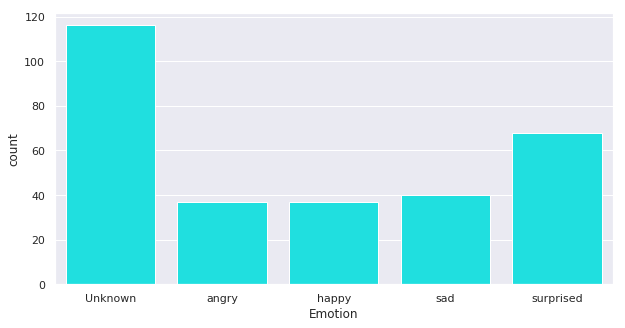

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(x='Emotion', data=traindf,
                   order=list(traindf['Emotion'].value_counts().sort_index().index) ,
                   color='cyan')

In [6]:
traindf.loc[traindf['Frame_ID'] == 'frame0.jpg']['Emotion']
class_names =np.unique(traindf['Emotion'])
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
print(class_names_label)

{'Unknown': 0, 'angry': 1, 'happy': 2, 'sad': 3, 'surprised': 4}


In [7]:
"""
import cv2
vidcap = cv2.VideoCapture('detect-emotions-of-your-favorite-toons/96714c94-6-Dataset/Dataset/Test Tom and jerry.mp4')

def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("/kaggle/input/detect-emotions-of-your-favorite-toons/frames/train_frames/"+str(count)+".jpg", image) # save frame as JPG file
    return hasFrames,image
train_images =[]
IMAGE_SIZE = (150,150)
sec = 1
frameRate = 1 #//it will capture image in each 0.5 second
count=1
success,image = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)
    
"""

'\nimport cv2\nvidcap = cv2.VideoCapture(\'detect-emotions-of-your-favorite-toons/96714c94-6-Dataset/Dataset/Test Tom and jerry.mp4\')\n\ndef getFrame(sec):\n    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)\n    hasFrames,image = vidcap.read()\n    if hasFrames:\n        cv2.imwrite("/kaggle/input/detect-emotions-of-your-favorite-toons/frames/train_frames/"+str(count)+".jpg", image) # save frame as JPG file\n    return hasFrames,image\ntrain_images =[]\nIMAGE_SIZE = (150,150)\nsec = 1\nframeRate = 1 #//it will capture image in each 0.5 second\ncount=1\nsuccess,image = getFrame(sec)\nwhile success:\n    count = count + 1\n    sec = sec + frameRate\n    sec = round(sec, 2)\n    success = getFrame(sec)\n    \n'

In [8]:
IMAGE_SIZE = (256, 256)
dataset = '/kaggle/input/detect-emotions-of-your-favorite-toons/frames/train_frames'
output = []
train_images = []
train_labels = []
for files in tqdm(os.listdir(dataset)):
    try:
        label=class_names_label[traindf.loc[traindf['Frame_ID'] == files]['Emotion'].values[0]]
    except:
        #do nothing
        a=1
    img_path=os.path.join(dataset, files)
    # Open and resize the img
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 
    # Append the image and its corresponding label to the output
    train_images.append(image)
    train_labels.append(label)

100%|██████████| 298/298 [00:05<00:00, 57.41it/s]


In [9]:
train_images = np.array(train_images, dtype = 'float32')/255
train_labels = np.array(train_labels, dtype = 'int32') 

In [10]:
IMAGE_SIZE = (256, 256)
dataset = '/kaggle/input/detect-emotions-of-your-favorite-toons/frames/test_frames'
output = []
test_images = []
for files in tqdm(os.listdir(dataset)):
    img_path=os.path.join(dataset, files)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 
    # Append the image and its corresponding label to the output
    test_images.append(image)
test_images = np.array(test_images, dtype = 'float32')/255

100%|██████████| 186/186 [00:02<00:00, 67.95it/s]


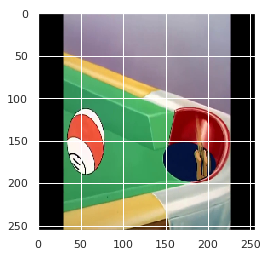

In [11]:
plt.imshow(test_images[25])

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(train_images,train_labels,test_size=0.3)

In [13]:
input_shape = x_train.shape[1:]
# Normalize data.
x_train = x_train.astype('float32') 
y_train = y_train.astype('float32') 
print(input_shape)

(256, 256, 3)


In [14]:
print(y_train.shape)
print(y_val.shape)

(208,)
(90,)


In [15]:
print(x_train.shape)
print(x_val.shape)

(208, 256, 256, 3)
(90, 256, 256, 3)


In [16]:
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
    from keras.optimizers import SGD
    from keras.callbacks import TensorBoard

In [17]:
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32,(3,3), input_shape = (256,256, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

#Adding more layers 
classifier.add(Conv2D(32,(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))

#Adding more layers 

classifier.add(Conv2D(32,(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Conv2D(32,(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))

# Step 3 - Flattening
classifier.add(Dropout(0.5))
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(output_dim = 300, activation = 'relu'))
classifier.add(Dense(output_dim = 100, activation = 'relu'))
classifier.add(Dense(output_dim = 5, activation = 'softmax'))

# Compiling the CNN
from keras import optimizers

#o = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(optimizer = Adam(lr=0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
epochs=50
classifier.fit(x_train,
             y_train,
             batch_size=32,
             nb_epoch=epochs,
             verbose=1,
             validation_data=(x_val,y_val))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=300)`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=100)`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5)`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 208 samples, validate on 90 samples
Epoch 1/50
208/208 [==============================] - 5s 25ms/step - loss: 1.5746 - accuracy: 0.3365 - val_loss: 1.4599 - val_accuracy: 0.4222
Epoch 2/50
208/208 [==============================] - 0s 1ms/step - loss: 1.4208 - accuracy: 0.3942 - val_loss: 1.3501 - val_accuracy: 0.4444
Epoch 3/50
208/208 [==============================] - 0s 1ms/step - loss: 1.3275 - accuracy: 0.4423 - val_loss: 1.2399 - val_accuracy: 0.4667
Epoch 4/50
208/208 [==============================] - 0s 2ms/step - loss: 1.2400 - accuracy: 0.4952 - val_loss: 1.1894 - val_accuracy: 0.4778
Epoch 5/50
208/208 [==============================] - 0s 1ms/step - loss: 1.1161 - accuracy: 0.5577 - val_loss: 1.3578 - val_accuracy: 0.5111
Epoch 6/50
208/208 [==============================] - 0s 1ms/step - loss: 0.9918 - accuracy: 0.5721 - val_loss: 1.1637 - val_accuracy: 0.5000
Epoch 7/50
208/208 [==============================] - 0s 1ms/step - loss: 0.9263 - accuracy: 0.6058 - 

In [18]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)       

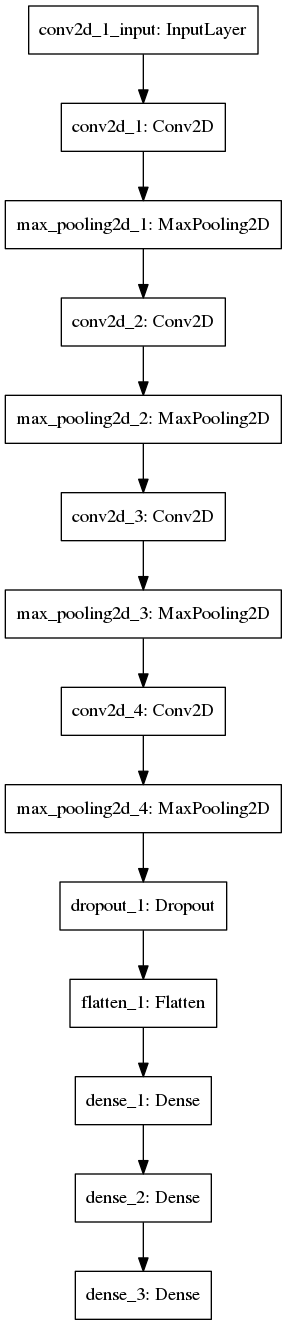

In [19]:
import pydot
keras.utils.plot_model(classifier)

In [20]:
scores = classifier.evaluate(x_val, y_val, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

90/90 [==============================] - 0s 618us/step
Test loss: 2.576635154088338
Test accuracy: 0.6777777671813965


In [21]:
y_test_prob = classifier.predict(test_images)
y_test_prob.round(2)

array([[1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.76, 0.2 , 0.  , 0.03, 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.9 , 0.  , 0.01, 0.  , 0.09],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.82, 0.  , 0.18, 0.  , 0.  ],
       [0.24, 0.76, 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , 0.25, 0.74],
       [0.23, 0.  , 0.34, 0.43, 0.01],
       [0.3 , 0.7 , 0.  , 0.  , 0.  ],
       [0.98, 0.  , 0.02, 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.99, 0.01, 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.06, 0.  , 0.94, 0.  , 0.  ],
       [0.  , 0.98, 0.  , 0.01, 0.01],
       [0.95, 0.01, 0.  , 0.  , 0.04],
       [0.  , 0.86, 0.  , 0.08, 0.05],
       [0.02, 0.98, 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.49, 0.01, 0.  , 0.48, 0.02],
       [0.98, 0.  , 0.  , 0.  , 0.01],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ,

In [22]:
y_test_pred = classifier.predict_classes(test_images)
y_test_pred

array([0, 0, 0, 0, 0, 0, 1, 4, 3, 1, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 3, 3, 0, 2, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 4, 1, 2, 3, 2, 0, 1, 3, 3, 1, 0, 0, 0, 3, 0,
       0, 1, 0, 3, 0, 2, 4, 4, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       1, 1, 1, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       4, 2, 4, 0, 0, 4, 0, 3, 0, 4, 0, 4, 0, 3, 3, 1, 1, 4, 0, 0, 0, 4,
       0, 4, 0, 0, 4, 0, 4, 0, 4, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 3, 0, 1])

In [23]:
elo = np.array(class_names)[y_test_pred]
elo

array(['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown',
       'angry', 'surprised', 'sad', 'angry', 'Unknown', 'Unknown',
       'Unknown', 'Unknown', 'happy', 'angry', 'Unknown', 'angry',
       'angry', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown',
       'Unknown', 'Unknown', 'angry', 'sad', 'Unknown', 'Unknown',
       'angry', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown',
       'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown',
       'Unknown', 'angry', 'angry', 'Unknown', 'sad', 'sad', 'Unknown',
       'happy', 'sad', 'Unknown', 'Unknown', 'Unknown', 'angry',
       'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown',
       'angry', 'Unknown', 'Unknown', 'angry', 'Unknown', 'Unknown',
       'angry', 'angry', 'Unknown', 'Unknown', 'Unknown', 'Unknown',
       'surprised', 'angry', 'happy', 'sad', 'happy', 'Unknown', 'angry',
       'sad', 'sad', 'angry', 'Unknown', 'Unknown', 'Unknown', 'sad',
       'Unknown', '

AxesImage(54,36;334.8x217.44) surprised


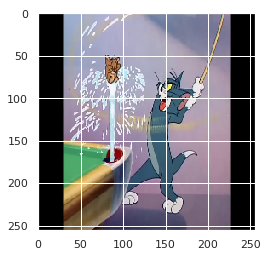

In [24]:
f=95
print(plt.imshow(test_images[f]),elo[f])

In [25]:
type(elo)

numpy.ndarray

In [26]:
df2 = testdf.assign(Emotion = elo) 

In [27]:
df2.head()

,Frame_ID,Emotion
0,test0.jpg,Unknown
1,test1.jpg,Unknown
2,test2.jpg,Unknown
3,test3.jpg,Unknown
4,test4.jpg,Unknown


In [28]:
df2.to_csv('submission2.csv', header=True, index=False)